# pcolorcells for plotting finite volume data

The matplotlib `pcolormesh` function is often used to plot finite volumen data via `pcolormesh(X,Y,Z,...)`, with `X,Y` being arrays of cell centers with the same shape as `Z`. In this case, the last row and column of `Z` are ignored as explained in the [pcolor documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolor.html). The values in `X,Y` are used as coordinates of cell edges rather than centers and so the data is also displaced from where it should be.

When frames of output are plotted using `visclaw` this does not happen because the cell edge arrays are used instead, with dimension one greater in each direction than that of `Z`.

However, in plotting topography using the `Topography.plot` function of GeoClaw, for example, this had not been done properly.  

This notebook explains the issue and a new function `visclaw.plottools.pcolorcells` that converts cell centers to edges if necessary before plotting with `pcolormesh`.

This is used in an improved version of `geoclaw.Topography.plot`.

This notebook also illustrates new functions to carefully choose the `dpi` parameter and image size to make versions that display well in Google Earth, and to make kml files to display them.  These are added to the `kmltools` module.

## Contents

- [The plottools.pcolorcells function](#pcolorcells)
- [Plotting topography](#topoplot)
- [Create a kml file with png to view](#kmlplot)

In [1]:
%matplotlib inline

In [3]:
from pylab import *
import sys
from importlib import reload
from clawpack.visclaw import colormaps, plottools
from clawpack.geoclaw import topotools, kmltools

## Define some sample data

Note that the `X,Y,Z` arrays are all 5 by 4 arrays.

Z has shape  (5, 4) X and Y have shape  (5, 4)


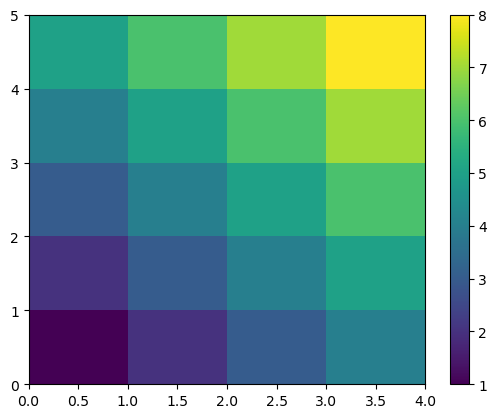

In [4]:
xcenter = linspace(0.5,3.5,4)
ycenter = linspace(0.5,4.5,5)
X,Y = meshgrid(xcenter,ycenter)
Z = X+Y
print('Z has shape ', Z.shape, 'X and Y have shape ', X.shape)

figure()
pcolormesh(X,Y,Z)
colorbar();

Note that only the lower 4x3 portion of `Z` is plotted above, with edges at the values set in `xcenter, ycenter`.

Instead we want to compute the edges and use these in the `pcolormesh` command:

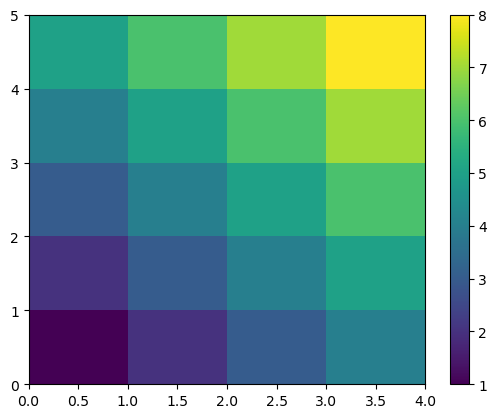

In [5]:
x = X[0,:]; y = Y[:,0]
dx=x[1]-x[0]; dy=y[1]-y[0]
xedge = np.arange(x[0]-0.5*dx, x[-1]+dx, dx)
yedge = np.arange(y[0]-0.5*dy, y[-1]+dy, dy)

pcolormesh(xedge,yedge,Z); colorbar();

<div id='pcolorcells'></div>

##  The `plottools.pcolorcells` function

This function allows passing in either cell centers or edges. You can also pass in any other `**kwargs` to be passed to `pcolormesh`.

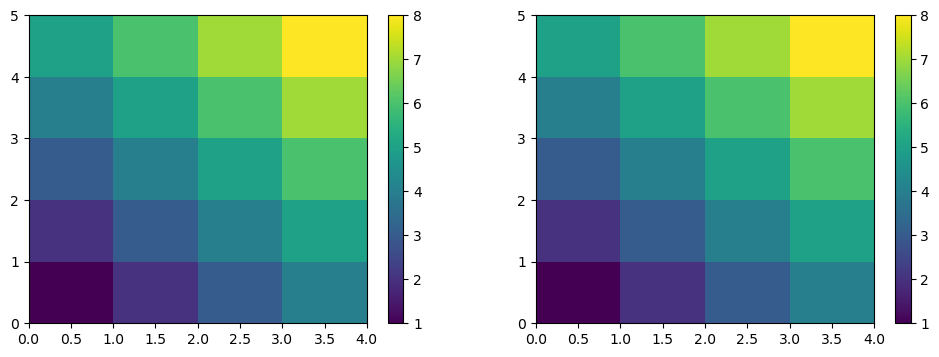

In [6]:
figure(figsize=(12,4))
subplot(121)
plottools.pcolorcells(xcenter, ycenter, Z);  colorbar()
subplot(122)
plottools.pcolorcells(xedge, yedge, Z);  colorbar();

You can also pass in 2d arrays `X,Y` that are either centers or edges:

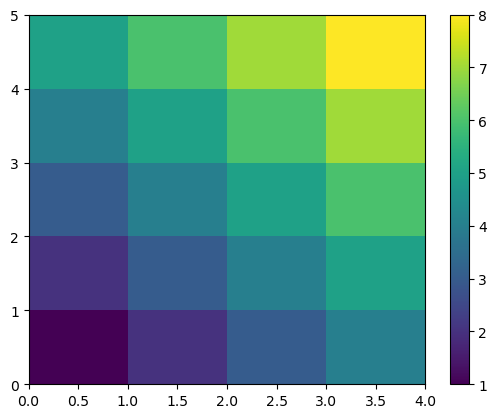

In [7]:
plottools.pcolorcells(X, Y, Z);  colorbar();

If we reduce the size of `Z` then `X,Y` are properly interpreted as edges:

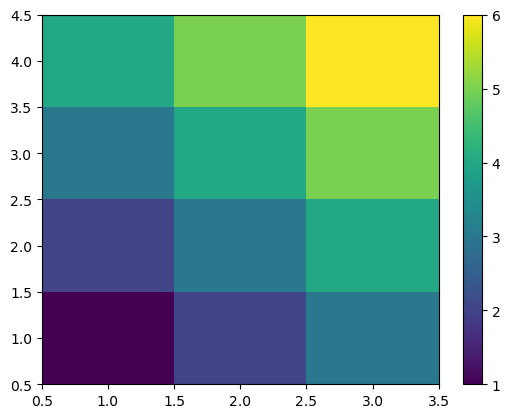

In [8]:
plottools.pcolorcells(X, Y, Z[:-1,:-1]);  colorbar();

## Contour plots

Note that contour plots assume the `X,Y` arrays are where pointwise values of `Z` are specified, so it is correct to use cell centers for this.  

As an example, define `Zbowl` to be a paraboloid with minimum at `(2,2)`:

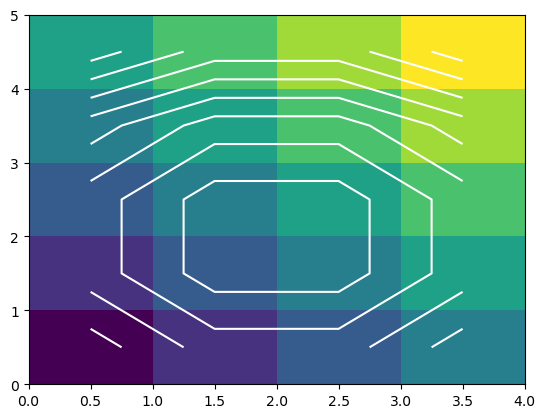

In [9]:
plottools.pcolorcells(X, Y, Z)

Zbowl = (X-2)**2 + (Y-2)**2
contour(X,Y,Zbowl,colors='w');

<div id='topoplot'></div>

## Plotting topography

When you load a topofile in GeoClaw, the internal represenation has `topo.X` and `topo.Y` at the cell centers of the DEM grid, and DEM values should be interpreted as either cell averages over these cells (in principle this is how they are defined) or as pointwise values at the cell centers (this is how we use them in GeoClaw when computing `B` values for grid cells by cell averaging a piecewise bilinear function interpolating at the cell centers).  For more information see  [the documentation](http://www.clawpack.org/topo.html).

The version of `clawpack.geoclaw.topotools` in Clawpack 5.6.0 uses `imshow` for plotting topography, unless the `Z` array is a `masked_array`, in which case it uses `pcolor` (which is slower than `imshow` and also slower than `pcolormesh`, which does work with masked arrays). Neither was done exactly properly in terms of plotting all cell values and properly aligning them.

The new version uses `pcolorcells` in both cases.

In [10]:
def topo_cmap(limits):
    topo_extent = limits
    data_break = 0.
    cmap_land = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                         0.25:[0.0,1.0,0.0],
                                          0.5:[0.8,1.0,0.5],
                                          1.0:[0.8,0.5,0.2]})
    cmap_water = get_cmap('Blues_r')
    if topo_extent[0] >= 0.0:
        cmap = cmap_land
        norm = colors.Normalize(vmin=0.0, vmax=topo_extent[1])
    elif topo_extent[1] <= 0.0:
        cmap = cmap_water
        norm = colors.Normalize(vmin=topo_extent[0], vmax=0.0)
    else:
        cmap, norm = colormaps.add_colormaps((cmap_land, cmap_water), 
                                             data_limits=topo_extent,
                                             data_break=data_break)
    return cmap, norm

### Sample data: 

We will download some sample data from the NCEI thredds server.  Note that this requires the `netCDF4` module.

A small set of 1-minute resolution etopo1 data covering part of Puget Sound around Seattle:

In [12]:
topo = topotools.read_netcdf('etopo1', extent=[-122.8,-122.3,47.5,47.8])

In [13]:
cmap,norm = topo_cmap((topo.Z.min(), topo.Z.max()))

Plot using new version of `topo.plot`, and add contour plot of shoreline and red dots at center of each grid cell (the values in `topo.X, topo.Y`).

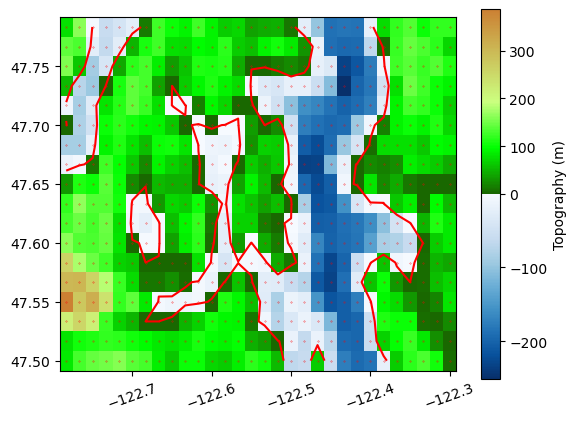

In [14]:
topo.plot()
contour(topo.X,topo.Y,topo.Z,[0],colors='r')
plot(topo.X, topo.Y, 'r.', markersize=0.5);

We can plot on top of a Google Earth image to check that things are lined up right:

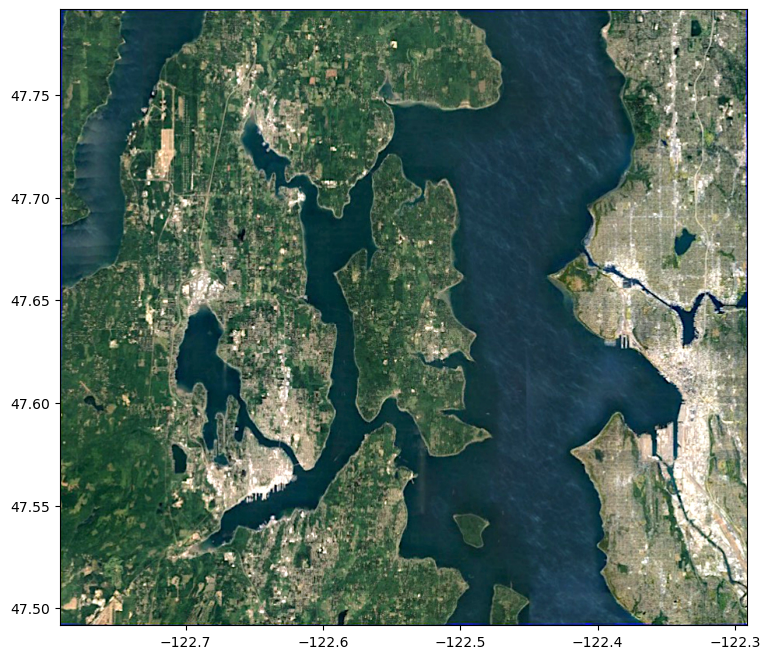

In [18]:
import urllib.request
from PIL import Image
# Expanded extent that include cells centered at the points in X,Y:
x1 = topo.x[0] - topo.delta[0]/2.; x2 = topo.x[-1] + topo.delta[0]/2.
y1 = topo.y[0] - topo.delta[1]/2.; y2 = topo.y[-1] + topo.delta[1]/2.
extent2 = [x1,x2,y1,y2]
    
if 0:
    # make a kml file to help grab the appropriate image from GE:
    kmltools.box2kml(extent2, fname='region2.kml', name='region2', width=1)

# load image for GE:
#region2_png = imread('http://www.clawpack.org/gallery/_static/figures/PStopoGE1.png')
# Cargar la imagen desde la URL utilizando urllib y PIL
url = 'http://www.clawpack.org/gallery/_static/figures/PStopoGE1.png'
with urllib.request.urlopen(url) as response:
    image = Image.open(response)

# Convertir la imagen a un array numpy
region2_png = np.array(image) 

figure(figsize=(12,8))
imshow(region2_png, extent=extent2)
gca().set_aspect(1./cos(48*pi/180.)); # fix aspect ratio

Plot the data on top of this image:

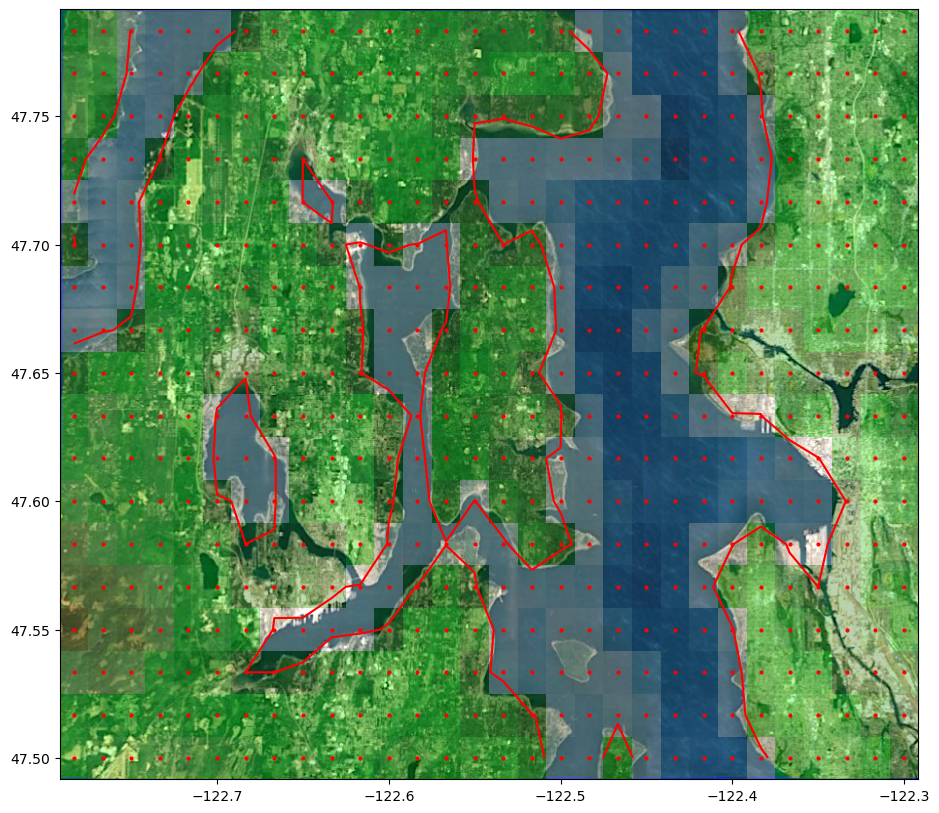

In [19]:
figure(figsize=(12,10))
imshow(region2_png, extent=extent2)
gca().set_aspect(1./cos(48*pi/180.)) # fix aspect ratio

plottools.pcolorcells(topo.X, topo.Y, topo.Z, cmap=cmap,norm=norm,alpha=0.3)
contour(topo.X,topo.Y,topo.Z,[0],colors='r')
plot(topo.X, topo.Y, 'r.', markersize=4);

<div id='kmlplot'></div>

## Create a kml file with png to view

A new function `pcolorcells_for_kml` has been added to `clawpack.geoclaw.kmltools` to create a png file that is suitable for viewing on Google Earth.  The new function `png2kml` can then be used to create the kml file that can be opened to view it.

The png image must be created carefully in order to get it lined up properly and also so that the interfaces between constant colors in grid cells are nice and sharp.  The approach taken in `pcolorcells_for_kml` is to:

 - Use the integer parameter `dpc` to determine how many "dots per cell" are desired,
 - Choose the image size and `dpi` (dots per inch) appropriately so there are an integer number of pixels in each grid cell,
 - Plot with no axes or margins so that only the cells are displayed.  Any margins would mess things up and result in a non-integer number of pixels in each cell.
 
The function returns several values that are useful if you want to further augment the plot before creating the png file.  This is illustrated later below, but first we use the `png_filename` parameter to create the png file internally.

Using kml_dpi = 20,figure size 15.000000 by 9.000000 inches
Figure has 30 by 18 grid cells of uniform color
Dots per cell in x: 10.000000,  in y: 10.000000
       These should be integers
Created  PStopo.png


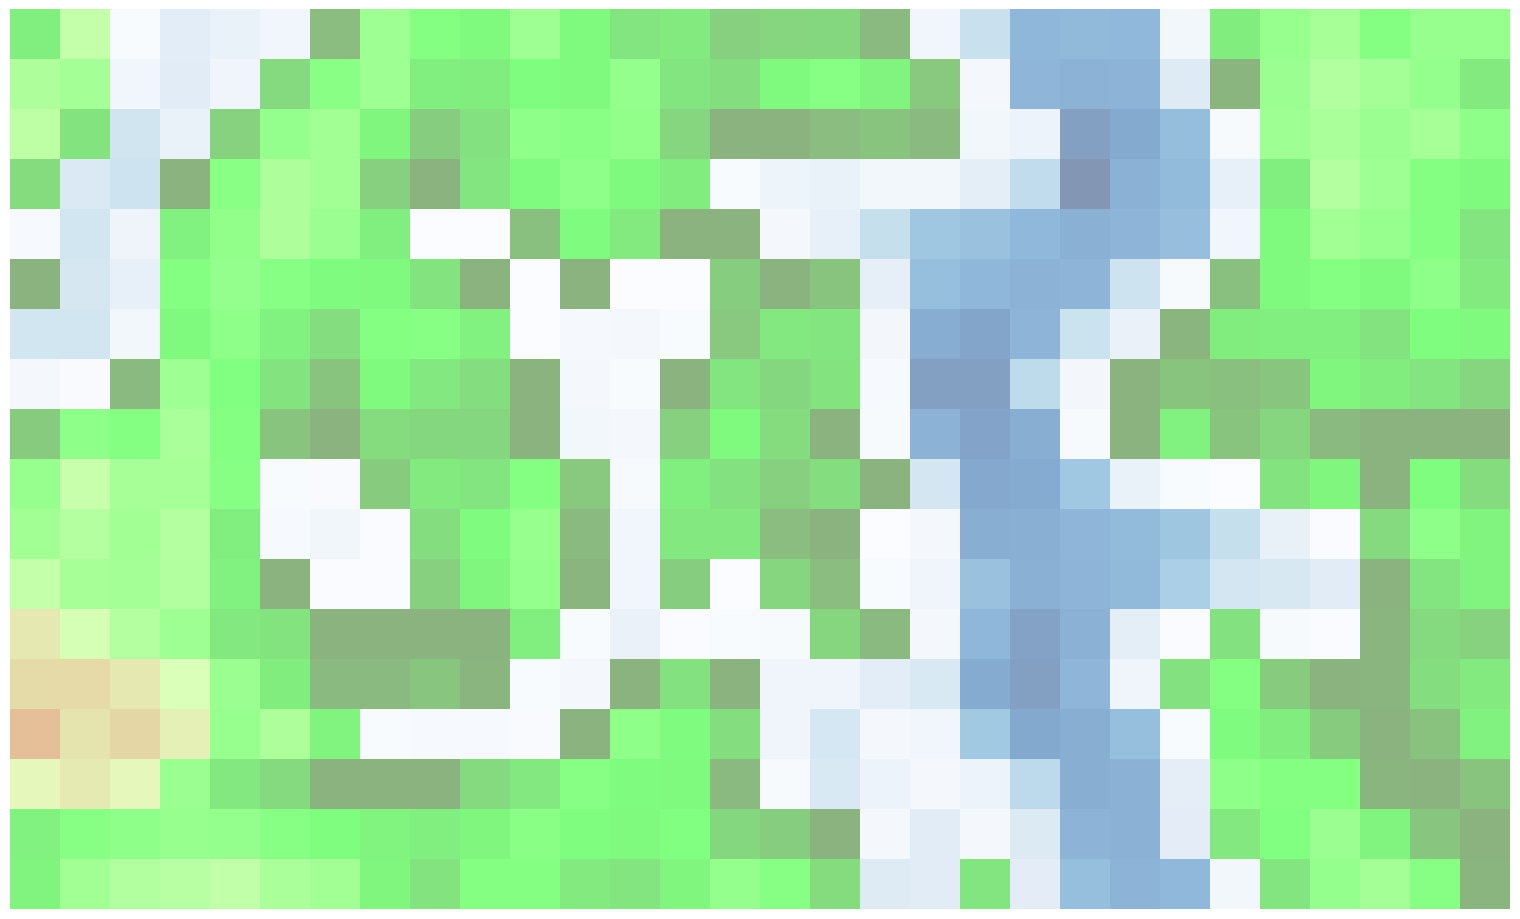

In [20]:
fig, ax, png_extent, kml_dpi = \
    kmltools.pcolorcells_for_kml(topo.X, topo.Y, topo.Z, 
                                 png_filename='PStopo.png', dpc=10,verbose=True,
                                 cmap=cmap,norm=norm, alpha=0.5)

We can now create the kml file that displays this image.  Note that `extent` should be the full extent out to the edges of the grid cells.

In [21]:
kmltools.png2kml(extent=extent2, png_files=['PStopo.png'],
                 png_names=['Puget Sound'], 
                 name='PStopo',
                 fname='PStopo.kml')

Extent:   -122.791667  -122.291667   47.491667   47.791667
Created  PStopo.kml


### Augment a plot before saving the png file

Using kml_dpi = 20,figure size 15.000000 by 9.000000 inches
Figure has 30 by 18 grid cells of uniform color
Dots per cell in x: 10.000000,  in y: 10.000000
       These should be integers


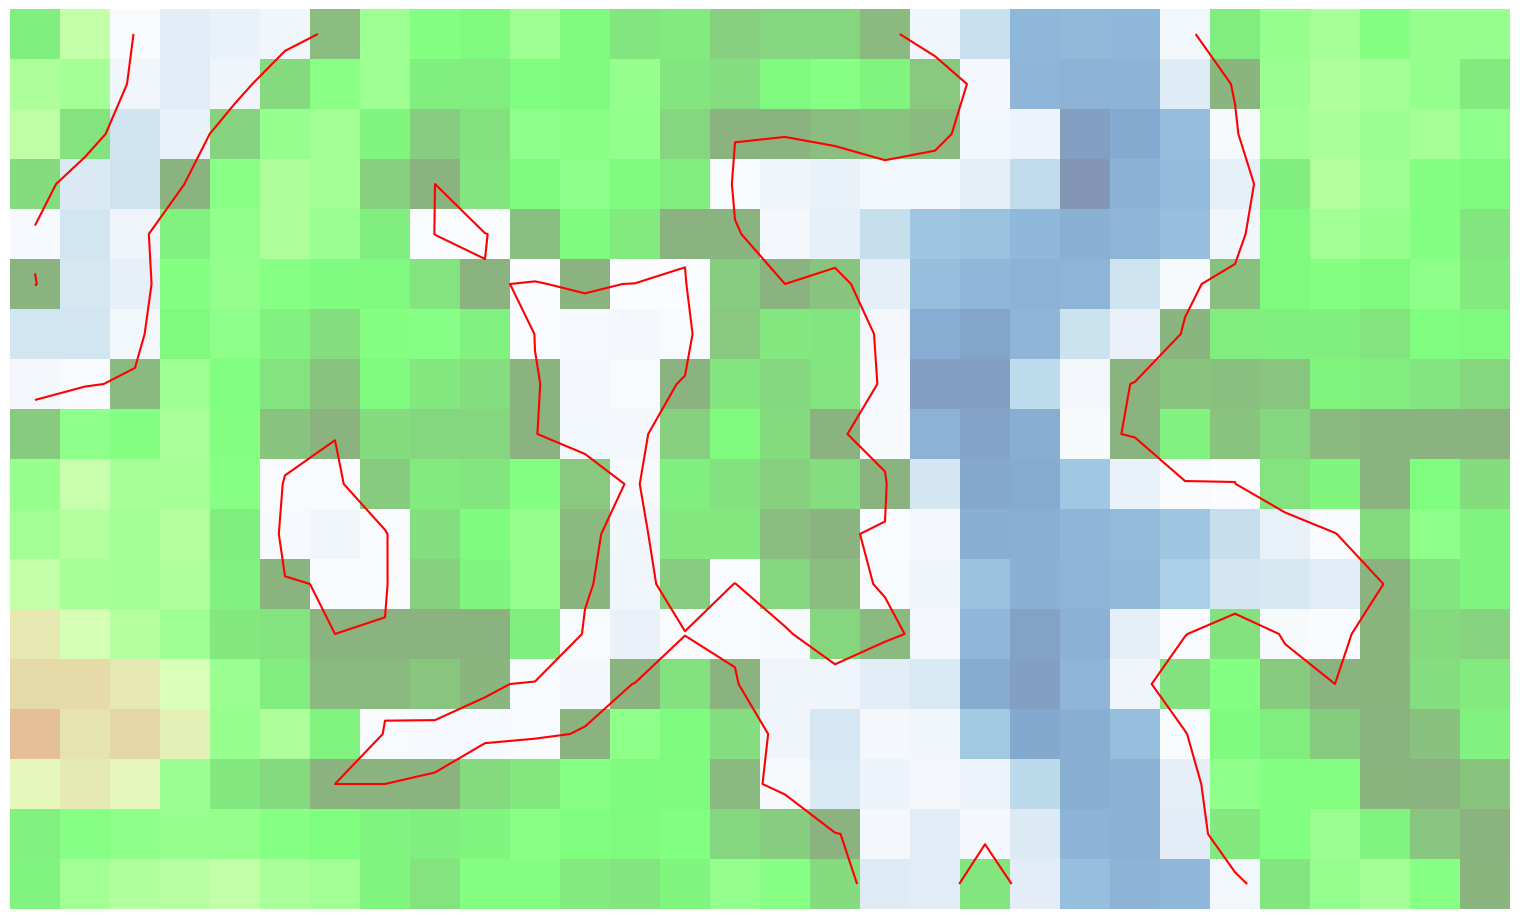

In [22]:
fig, ax, png_extent, kml_dpi = \
    kmltools.pcolorcells_for_kml(topo.X, topo.Y, topo.Z, 
                                 png_filename=None, dpc=10,verbose=True,
                                 cmap=cmap,norm=norm, alpha=0.5)
ax.contour(topo.X, topo.Y, topo.Z, [0], colors='r')

savefig('PStopo2.png', transparent=True, dpi=kml_dpi)

Now make a new kml file, also illustrating that you can also specify a list of png files (and associated names) and they will all be displayed together, with a menu allowing you to turn each on or off.  Setting the parameter `radio_style=True` will give a version in which at most one of the png files can be displayed at a time.

In [26]:
kmltools.png2kml(extent=extent2, png_files=['PStopo.png','PStopo2.png'],
                 png_names=['Puget Sound', 'with shoreline'], 
                 name='PStopo',
                 fname='PStopo.kml',
                 radio_style=True)

Extent:   -122.791667  -122.291667   47.491667   47.791667
Created  PStopo.kml


Here's a screenshot of the result:

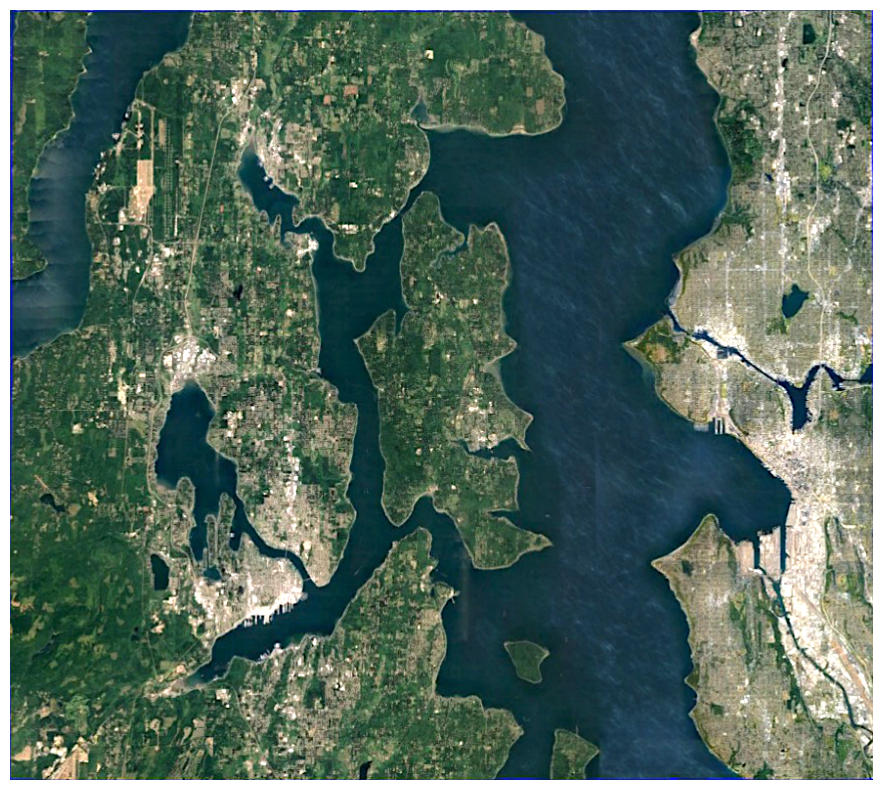

In [27]:
figure(figsize=(12,10))
#PStopoGE = imread('http://www.clawpack.org/gallery/_static/figures/PStopoGE2.png')
# Descargar y abrir la imagen desde la URL
with urllib.request.urlopen(url) as response:
    image = Image.open(response)

# Convertir la imagen a un array numpy
PStopoGE = np.array(image)
imshow(PStopoGE)
axis('off');